In [102]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pathlib import Path
import os
os.chdir('/Users/ty/Downloads/STAT6207/STAT6207_project')

torch.manual_seed(42)
# Paths to the CSV files
data_folder = Path("data")
data_folder.mkdir(parents=True, exist_ok=True)
train_path = data_folder / "train_all_cols_unstd_v2.csv"
test_path = data_folder / "test_all_cols_unstd_v2.csv"

# Load the data
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Separate features and target
TARGET_COL = "Next_Q1"
OPP_TARGET_COL = "Next_Q1_log1p"

# Optionally keep target as log1p for modeling
y_train = train_df[OPP_TARGET_COL]
y_test = test_df[OPP_TARGET_COL]

# Drop id column and all *_log1p columns from features
cols_to_drop_train = ['isbn'] + [TARGET_COL] + ['Next_Q2'] + ['Next_Q3'] + ['Next_Q4']
cols_to_drop_test = ['isbn'] + [TARGET_COL] + ['Next_Q2'] + ['Next_Q3'] + ['Next_Q4']

X_train = train_df.drop(columns=cols_to_drop_train)
X_test = test_df.drop(columns=cols_to_drop_test)


In [103]:
# Exactly the same columns (names and order)
print(list(X_train.columns) == list(X_test.columns))


True


In [104]:
# Enforce same columns and order on test
X_test = X_test[X_train.columns]

# Convert to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [105]:
# Check for nulls in train and test dataframes
print("Null counts in train_df:")
print(train_df.isnull().sum())
print("\nNull counts in test_df:")
print(test_df.isnull().sum())

Null counts in train_df:
isbn                                0
print_length                        0
item_weight                         0
length                              0
width                               0
height                              0
rating                              0
number_of_reviews                   0
price                               0
customer_reviews                    0
channel                             0
Previous_quarter_qty                0
Current_quarter_qty                 0
Next_Q1                             0
Next_Q2                             0
Next_Q3                             0
Next_Q4                             0
Avg_discount_cleaned                0
book_format_board_book              0
book_format_cards                   0
book_format_hardcover               0
book_format_library_binding         0
book_format_paperback               0
reading_age_adolescence or above    0
reading_age_baby                    0
reading_age_preadolescenc

In [106]:
# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define a simple feedforward neural network for regression
class Regressor(nn.Module):
    def __init__(self, input_dim: int, drop_out: float):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.model(x)

input_dim = X_train_tensor.shape[1]
model = Regressor(input_dim=input_dim, drop_out=0)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 100
model.train()
loss_history = []

for epoch in range(epochs):
    epoch_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * xb.size(0)

    epoch_loss /= len(train_loader.dataset)
    loss_history.append(epoch_loss)

# Evaluate on test set
model.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    preds_test = model(X_test_device).cpu().numpy().flatten()

true_test = y_test_tensor.numpy().flatten()
rmse = np.sqrt(mean_squared_error(true_test, preds_test))
print(f"Test RMSE: {rmse:.4f}")

Test RMSE: 0.1497


In [107]:
# Save true and predicted values into a DataFrame
results_df = pd.DataFrame({
    "true_next_q1_log1p": true_test,
    "pred_next_q1_log1p": preds_test,
})
results_df

,true_next_q1_log1p,pred_next_q1_log1p
0,3.818550,3.735678
1,2.124250,2.236095
2,0.132352,0.196939
3,2.189032,2.060130
4,2.566967,2.468051
...,...,...
8557,0.393151,0.412979
8558,-0.863597,-0.876923
8559,1.021525,1.011634
8560,2.219765,2.224661


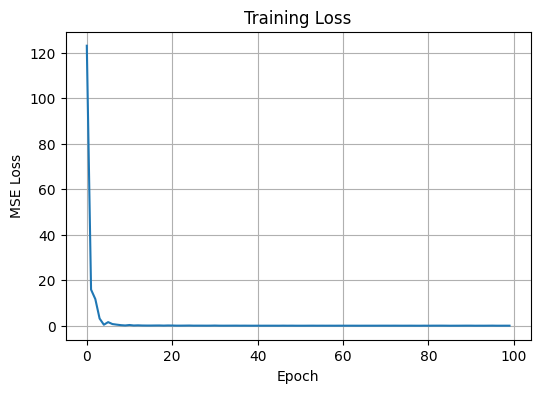

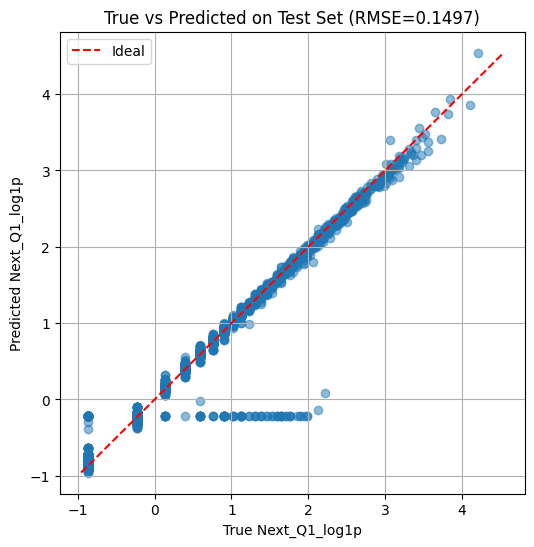

In [108]:
# Plot training loss
plt.figure(figsize=(6, 4))
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()

# Plot true vs predicted on test set
plt.figure(figsize=(6, 6))
plt.scatter(true_test, preds_test, alpha=0.5)
min_val = min(true_test.min(), preds_test.min())
max_val = max(true_test.max(), preds_test.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--", label="Ideal")
plt.xlabel("True Next_Q1_log1p")
plt.ylabel("Predicted Next_Q1_log1p")
plt.title(f"True vs Predicted on Test Set (RMSE={rmse:.4f})")
plt.legend()
plt.grid(True)
plt.show()